In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist_train = pd.read_csv('mnist_train.csv')
mnist_test = pd.read_csv('mnist_test.csv')

In [4]:
mnist_train.shape, mnist_test.shape

((60000, 785), (10000, 785))

In [5]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


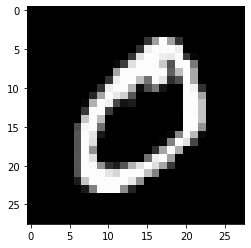

In [8]:
img = mnist_train[1:2]
img = img.drop(columns='label').values
plt.imshow(img.reshape(28,28), cmap='gray');

In [9]:
mnist_train.dropna(inplace=True)
mnist_test.dropna(inplace=True)

In [10]:
X_train = mnist_train.drop(columns='label')
y_train = mnist_train['label']
X_test = mnist_test.drop(columns='label')
y_test = mnist_test['label']

In [11]:
X_train = X_train.values.astype('float32')
X_train = X_train / 255.

In [12]:
X_test = X_test.values.astype('float32')
X_test = X_test / 255.

In [13]:
X_train.max(), X_test.max()

(1.0, 1.0)

In [14]:
import torch
print(torch.__version__)

1.10.0+cu111


In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([60000]),
 torch.Size([10000]))

In [17]:
import torch.nn as nn

In [18]:
INPUT = 784
OUTPUT = 10
HIDDEN = [16, 32]

In [19]:
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()
    self.fc1 = nn.Linear(INPUT, HIDDEN[0])
    self.fc2 = nn.Linear(HIDDEN[0], HIDDEN[1])
    self.fc3 = nn.Linear(HIDDEN[1], OUTPUT)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = self.fc3(x)

    return torch.log_softmax(x, dim=-1)

In [20]:
model = Net()

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [22]:
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [24]:
import torch.optim as optim

In [25]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
EPOCHS = 500

for epoch in range(1, EPOCHS + 1):

  optimizer.zero_grad()
  y_pred = model(X_train_tensor)

  loss = loss_fn(y_pred, y_train_tensor)
  loss.backward()

  optimizer.step()

  if epoch % 50 == 0:
    print(f'Epoch: [{epoch}/{EPOCHS}] | loss: {loss:.2f}')

Epoch: [50/500] | loss: 2.22
Epoch: [100/500] | loss: 1.98
Epoch: [150/500] | loss: 1.70
Epoch: [200/500] | loss: 1.46
Epoch: [250/500] | loss: 1.26
Epoch: [300/500] | loss: 1.09
Epoch: [350/500] | loss: 0.94
Epoch: [400/500] | loss: 0.82
Epoch: [450/500] | loss: 0.72
Epoch: [500/500] | loss: 0.63


In [26]:
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [30]:
with torch.no_grad():
  correct = 0
  total = 0

  outputs = model(X_test_tensor)
  _, predicted = torch.max(outputs.data, 1)

  y_test = y_test_tensor.cpu().numpy()
  predicted = predicted.cpu()

  print(f'Accuracy: {accuracy_score(predicted, y_test):.4f}')
  print(f'Precision: {precision_score(predicted, y_test, average="weighted"):.4f}')
  print(f'Recall: {recall_score(predicted, y_test, average="weighted"):.4f}')

Accuracy: 0.8660
Precision: 0.8722
Recall: 0.8660
